In [8]:
import time
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification
from transformers import AutoTokenizer, TrainingArguments, Trainer
import numpy as np
import evaluate
import torch
from torch.utils.data import DataLoader
from peft import LoraConfig, TaskType, get_peft_model
from sklearn.metrics import accuracy_score
from torch.nn import CrossEntropyLoss
import copy

/home/liuyuan/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# # torch.cuda.empty_cache()
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [10]:
BATCH_SIZE = 16

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [11]:
def set_seed(seed):
    # Set seed for NumPy
    np.random.seed(seed)
    
    
    # Set seed for PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    
    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
seed = 2024
set_seed(seed)

## model & data preparation 

In [12]:
raw_datasets = load_dataset("imdb") 
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", padding="max_length", truncation=True)

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets = tokenized_datasets.with_format("torch")

In [14]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [15]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(2000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))
full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]

train_loader = DataLoader(dataset= small_train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)


# Create DataLoader for the test dataset
test_loader = DataLoader(dataset= small_eval_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

In [16]:
# Pretrained model
checkpoint = "google-bert/bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels = 2)

model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Self-defined trainer

## Dora Trainer

In [17]:
# Function to calculate accuracy
def compute_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predictions = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_loader:
            # Move batch to the correct device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Get model predictions
            outputs = model(**batch)
            logits = outputs.logits
            
            # Get predicted class (highest logit value)
            preds = torch.argmax(logits, dim=-1)
            
            # Store true labels and predictions
            true_labels.extend(batch["labels"].cpu().numpy())
            predictions.extend(preds.cpu().numpy())
    
    # Compute accuracy
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy
    
def compute_loss(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        loss_total = 0
        for batch in data_loader:
            # Move batch to the correct device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Get model predictions
            outputs = model(**batch)

            loss_total += outputs.loss.item()
        return loss_total/len(data_loader)

In [18]:
# Hyperparameters
random_seed = 123
torch.manual_seed(random_seed)

num_epochs = 20

# optimizer
learning_rate = 5e-4 # 0.005

def train(num_epochs, model, optimizer, train_loader, device, test_loader = test_loader):
    # record
    tr_acc=[compute_accuracy(model, train_loader, device)]
    tr_loss=[compute_loss(model, train_loader, device)]
    
    test_acc=[compute_accuracy(model, test_loader, device)]
    test_loss=[compute_loss(model, test_loader, device)]
    
    time_stamp=[0]
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        model.train()
        print(f"Epoch {epoch+1}/{num_epochs}")
        total_loss = 0
        for batch in train_loader:
            # Move data to the correct device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss # automatically cross entropy
            total_loss += loss.item()
    
            # Backward pass and optimization
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

        # recording
        train_time = (time.time() - start_time)
        time_stamp.append(time_stamp[-1]+train_time)

        tr_acc.append(compute_accuracy(model, train_loader, device))
        tr_loss.append(compute_loss(model, train_loader, device))
        
        test_acc.append(compute_accuracy(model, test_loader, device))
        test_loss.append(compute_loss(model, test_loader, device))
        
        print('Time elapsed: %.2f min' % (time_stamp[-1]/60))
        print(f"Epoch {epoch+1} Training Loss: {tr_loss[-1]}")
        print(f"Epoch {epoch+1} Training Accuracy: {tr_acc[-1]}")
        
    return (tr_acc,tr_loss), (test_acc,test_loss), (time_stamp)

## BiDora Trainer

In [19]:
def compute_regularization(B, A, device = DEVICE):
        V = torch.matmul(B, A)  # V = B @ A
        delta_V = torch.zeros_like(V)  # Placeholder for Delta V, update based on the iteration context
        reg_term = torch.norm((V + delta_V).T @ (V + delta_V) - torch.eye(V.shape[1], device=device), p='fro')**2
        # reg_term = torch.norm(V.T @ V - torch.eye(V.shape[1], device=device), p='fro')**2
        return reg_term

def compute_val_loss(model,val_loader, device=DEVICE):
    model.train()
    # Validation Loss Computation
    batch = next(iter(val_loader))

    batch = {k: v.to(device) for k, v in batch.items()}
            
    # Forward pass
    outputs = model(**batch)
    loss = outputs.loss # automatically cross entropy
    return loss #/batch.size(0)

def freeze_layers(model, freeze_lora_magnitude=True, freeze_lora_embedding=True):
    # Freeze lora_magnitude_vector
    if freeze_lora_magnitude:
        for name, param in model.named_parameters():
            if 'lora_magnitude_vector' in name:
                param.requires_grad = False
            if 'lora_embedding_A' in name or 'lora_embedding_B' in name:
                param.requires_grad = True
    
    # Freeze lora_embedding_A and lora_embedding_B
    if freeze_lora_embedding:
        for name, param in model.named_parameters():
            if 'lora_magnitude_vector' in name:
                param.requires_grad = True
            if 'lora_embedding_A' in name or 'lora_embedding_B' in name:
                param.requires_grad = False

In [20]:
args = {"gamma":15,
       "lamba": 1e-3,
       "inner_lr":5e-4,
       "learning_rate":5e-4,
       "tokenized_train_dataset": small_train_dataset,
       "tokenized_test_dataset": small_eval_dataset,
       "prop_train": 0.66}

def train_bidora_penalty(num_epochs, model, args = args, device=DEVICE, penalty_term=True):
    gamma=args["gamma"]
    lamba=args["lamba"]
    inner_lr=args["inner_lr"]
    learning_rate=args["learning_rate"]
    tokenized_train_dataset=args["tokenized_train_dataset"]
    tokenized_test_dataset=args["tokenized_test_dataset"]
    prop_train=args["prop_train"]
    
    train_size = int(prop_train * len(tokenized_train_dataset))
    val_size = len(tokenized_train_dataset) - train_size
    ab_train_dataset = tokenized_train_dataset.select(range(train_size))
    m_train_dataset = tokenized_train_dataset.select(range(train_size,train_size+val_size))
    # Create DataLoaders for training and validation
    train_loader = DataLoader(dataset=ab_train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
    
    val_loader = DataLoader(dataset=m_train_dataset,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True)

    test_loader = DataLoader(dataset=tokenized_test_dataset,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True)
    # record
    tr_acc=[compute_accuracy(model, train_loader, device)]
    tr_loss=[compute_loss(model, train_loader, device)]
    
    test_acc=[compute_accuracy(model, test_loader, device)]
    test_loss=[compute_loss(model, test_loader, device)]
    
    time_stamp=[0]
    
    for epoch in range(num_epochs):
        start_time = time.time()
        # model.train()
        print(f"Epoch {epoch+1}/{num_epochs}")
    
        total_loss = 0
        for batch_val in val_loader:
            batch_val = {k: v.to(device) for k, v in batch_val.items()}

            # Phase 1: Update A and B, freeze m
            freeze_layers(model, freeze_lora_magnitude=True, freeze_lora_embedding=False)
            
            optimizer_ab = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=inner_lr)
            
            ### LL inner loop
            if penalty_term:
                model_LL = copy.deepcopy(model) # it has been freezed accordingly
                optimizer_LL = torch.optim.Adam(filter(lambda p: p.requires_grad, model_LL.parameters()), lr=inner_lr)
                
            for i in range(2):#(int(prop_train/(1-prop_train))): # as number of train data is 9 times more than validation data
                model.train()

                batch = next(iter(train_loader))
                batch = {k: v.to(device) for k, v in batch.items()}

                # Forward and backward pass
                outputs = model(**batch)
                loss_train = outputs.loss
                
                # loss_val = compute_val_loss(model)
                outputs_val = model(**batch_val)
                loss_val = outputs_val.loss

                loss_reg = 0
                for name, param in model.named_parameters():
                    for name2, param2 in model.named_parameters():
                        if "lora_embedding_A" in name and "lora_embedding_B" in name2 and name[7]==name2[7]: # 7 is the layer number
                            loss_reg += compute_regularization(param, param2)
                # print(loss_train,loss_val,loss_reg)
                loss = 1/gamma* loss_val  + loss_train + lamba* loss_reg


                optimizer_ab.zero_grad()
                loss.backward()
                optimizer_ab.step()

                if penalty_term:
                    model_LL.train()
                    outputs = model_LL(**batch)
                    loss_train_LL = outputs.loss

                    optimizer_LL.zero_grad()
                    loss_train_LL.backward()

                    optimizer_LL.step()


            # Phase 2:
            # Freeze all ab, unfreeze m
            freeze_layers(model, freeze_lora_magnitude=False, freeze_lora_embedding=True)

            optimizer_m = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

            # upper loss
            outputs_m = model(**batch_val)
            loss_m = outputs_m.loss


            #penalty term
            if penalty_term:
                freeze_layers(model_LL, freeze_lora_magnitude=False, freeze_lora_embedding=True)
                optimizer_m = torch.optim.Adam(filter(lambda p: p.requires_grad, list(model.parameters()) + list(model_LL.parameters())),lr=1e-3)

                batch = next(iter(train_loader))
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs_LL = model_LL(**batch)
                outputs = model(**batch)
                
                # Forward and backward pass
                loss_train_LL = outputs_LL.loss
                loss_train = outputs.loss

                loss_m += gamma*(loss_train-loss_train_LL)

            
            total_loss += loss_m
            
            optimizer_m.zero_grad()
            loss_m.backward()
            optimizer_m.step()

        # recording
        train_time = (time.time() - start_time)
        time_stamp.append(time_stamp[-1]+train_time)

        tr_acc.append(compute_accuracy(model, train_loader, device))
        tr_loss.append(compute_loss(model, train_loader, device))
        
        test_acc.append(compute_accuracy(model, test_loader, device))
        test_loss.append(compute_loss(model, test_loader, device))
        
        print('Time elapsed: %.2f min' % (time_stamp[-1]/60))
        print(f"Epoch {epoch+1} Training Loss: {tr_loss[-1]}")
        print(f"Epoch {epoch+1} Training Accuracy: {tr_acc[-1]}")
        
    return (tr_acc,tr_loss), (test_acc,test_loss), (time_stamp)

# Train Dora, BiDora, BiDora_vaff

## Train Dora

In [53]:
num_exp = 10
num_epochs = 10
learning_rate =5e-4

# output_dora_list = []

checkpoint = "google-bert/bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels = 2)
model_dora = copy.deepcopy(model) # AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels = 2)
peft_config_dora = LoraConfig(use_dora=True, task_type=TaskType.SEQ_CLS, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1)
model_dora = get_peft_model(model_dora, peft_config_dora)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for i in range(10,20):
    set_seed(i)
    print("random_seed:",i)
    print("========Iteration:",i,"=========")
    model_dora_=copy.deepcopy(model_dora)
    model_dora_.to(DEVICE)
    optimizer = torch.optim.Adam(model_dora_.parameters(), lr=learning_rate)
    output_dora = train(num_epochs, model_dora_, optimizer, train_loader, DEVICE, test_loader)
    output_dora_list.append(output_dora)
    print(f'Test accuracy DoRA finetune: {compute_accuracy(model_dora_, test_loader, DEVICE):.2f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


random_seed: 10
========Iteration: 10 =========
Epoch 1/10
Time elapsed: 0.84 min
Epoch 1 Training Loss: 0.23711628299951554
Epoch 1 Training Accuracy: 0.907
Epoch 2/10
Time elapsed: 1.68 min
Epoch 2 Training Loss: 0.20875830414891244
Epoch 2 Training Accuracy: 0.9235
Epoch 3/10
Time elapsed: 2.52 min
Epoch 3 Training Loss: 0.149178175881505
Epoch 3 Training Accuracy: 0.9465
Epoch 4/10
Time elapsed: 3.36 min
Epoch 4 Training Loss: 0.06622747743874788
Epoch 4 Training Accuracy: 0.98
Epoch 5/10
Time elapsed: 4.19 min
Epoch 5 Training Loss: 0.047501403745263814
Epoch 5 Training Accuracy: 0.986
Epoch 6/10
Time elapsed: 5.02 min
Epoch 6 Training Loss: 0.03674123250506818
Epoch 6 Training Accuracy: 0.988
Epoch 7/10
Time elapsed: 5.86 min
Epoch 7 Training Loss: 0.023673256603069605
Epoch 7 Training Accuracy: 0.9935
Epoch 8/10
Time elapsed: 6.69 min
Epoch 8 Training Loss: 0.017633233219385147
Epoch 8 Training Accuracy: 0.9965
Epoch 9/10
Time elapsed: 7.53 min
Epoch 9 Training Loss: 0.007397783

In [54]:
output_dir = "output_movie/"
with open(output_dir+"output_dora_list.txt", "w") as f:
    f.write(str(output_dora_list))

In [46]:
# output_bidora_vaff_list = []
num_exp = 10
num_epochs = 10
learning_rate = 5e-4


checkpoint = "google-bert/bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels = 2)
model_dora = copy.deepcopy(model) # AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels = 2)
peft_config_dora = LoraConfig(use_dora=True, task_type=TaskType.SEQ_CLS, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1)
model_dora = get_peft_model(model_dora, peft_config_dora)

args = {"gamma":15,
       "lamba": 1e-3,
       "inner_lr":5e-4,
       "learning_rate":5e-4,
       "tokenized_train_dataset": small_train_dataset,
       "tokenized_test_dataset": small_eval_dataset,
       "prop_train": 0.66}


for i in range(10,20):
    set_seed(i)
    print("random_seed:",i)
    print("======== Iteration:",i,"=========")
    model_dora_=copy.deepcopy(model_dora)
    model_dora_.to(DEVICE)
    output_dora = train_bidora_penalty(num_epochs, model_dora_,args=args,penalty_term=False)
    output_bidora_vaff_list.append(output_dora)
    print(f'Test accuracy DoRA finetune: {compute_accuracy(model_dora_, test_loader, DEVICE):.2f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


random_seed: 10
======== Iteration: 10 =========
Epoch 1/10
Time elapsed: 2.59 min
Epoch 1 Training Loss: 0.270434730473053
Epoch 1 Training Accuracy: 0.8916666666666667
Epoch 2/10
Time elapsed: 5.16 min
Epoch 2 Training Loss: 0.2533334973324315
Epoch 2 Training Accuracy: 0.9128787878787878
Epoch 3/10
Time elapsed: 7.76 min
Epoch 3 Training Loss: 0.305165510310466
Epoch 3 Training Accuracy: 0.8863636363636364
Epoch 4/10
Time elapsed: 10.32 min
Epoch 4 Training Loss: 0.17657837540988464
Epoch 4 Training Accuracy: 0.9507575757575758
Epoch 5/10
Time elapsed: 12.91 min
Epoch 5 Training Loss: 0.15662793467152325
Epoch 5 Training Accuracy: 0.9674242424242424
Epoch 6/10
Time elapsed: 15.48 min
Epoch 6 Training Loss: 0.18357188894177776
Epoch 6 Training Accuracy: 0.9628787878787879
Epoch 7/10
Time elapsed: 18.08 min
Epoch 7 Training Loss: 0.16447734631771918
Epoch 7 Training Accuracy: 0.9636363636363636
Epoch 8/10
Time elapsed: 20.64 min
Epoch 8 Training Loss: 0.387529128909024
Epoch 8 Trainin

In [47]:
output_dir = "output_movie/"
with open(output_dir+"output_bidora_vaff_list.txt", "w") as f:
    f.write(str(output_bidora_vaff_list))

In [42]:
# output_bidora_vaff_list = []
num_exp = 10
num_epochs = 10
learning_rate = 5e-4


checkpoint = "google-bert/bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels = 2)
model_dora = copy.deepcopy(model) # AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels = 2)
peft_config_dora = LoraConfig(use_dora=True, task_type=TaskType.SEQ_CLS, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1)
model_dora = get_peft_model(model_dora, peft_config_dora)

args = {"gamma":15,
       "lamba": 1e-3,
       "inner_lr":5e-4,
       "learning_rate":5e-4,
       "tokenized_train_dataset": small_train_dataset,
       "tokenized_test_dataset": small_eval_dataset,
       "prop_train": 0.66}


for i in range(1):
    set_seed(i)
    print("random_seed:",i)
    print("======== Iteration:",i,"=========")
    model_dora_=copy.deepcopy(model_dora)
    model_dora_.to(DEVICE)
    output_dora = train_bidora_penalty(num_epochs, model_dora_,args=args,penalty_term=True)
    output_bidora_list.append(output_dora)
    print(f'Test accuracy DoRA finetune: {compute_accuracy(model_dora_, test_loader, DEVICE):.2f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


random_seed: 0
======== Iteration: 0 =========
Epoch 1/10
Time elapsed: 4.82 min
Epoch 1 Training Loss: 0.355393648147583
Epoch 1 Training Accuracy: 0.8818181818181818
Epoch 2/10
Time elapsed: 9.61 min
Epoch 2 Training Loss: 0.30436127421906195
Epoch 2 Training Accuracy: 0.906060606060606
Epoch 3/10
Time elapsed: 14.44 min
Epoch 3 Training Loss: 0.1443246943113136
Epoch 3 Training Accuracy: 0.9492424242424242
Epoch 4/10
Time elapsed: 19.22 min
Epoch 4 Training Loss: 0.15693296451705047
Epoch 4 Training Accuracy: 0.9553030303030303
Epoch 5/10
Time elapsed: 24.01 min
Epoch 5 Training Loss: 0.10689694115734961
Epoch 5 Training Accuracy: 0.9651515151515152
Epoch 6/10
Time elapsed: 28.82 min
Epoch 6 Training Loss: 0.14133730093269686
Epoch 6 Training Accuracy: 0.956060606060606
Epoch 7/10
Time elapsed: 33.63 min
Epoch 7 Training Loss: 0.03661943122980196
Epoch 7 Training Accuracy: 0.9931818181818182
Epoch 8/10
Time elapsed: 38.42 min
Epoch 8 Training Loss: 0.0536859791382852
Epoch 8 Trainin

In [43]:
output_dir = "output_movie/"
with open(output_dir+"output_bidora_list.txt", "w") as f:
    f.write(str(output_bidora_list))

20

## Train model

In [12]:
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
output = train(num_epochs, model, optimizer, train_loader, DEVICE)
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}')

Epoch 1/10
Time elapsed: 0.47 min
Epoch 1 Training Loss: 0.5832200199365616
Epoch 1 Training Accuracy: 0.648
Epoch 2/10
Time elapsed: 0.94 min
Epoch 2 Training Loss: 0.26740402774885297
Epoch 2 Training Accuracy: 0.915
Epoch 3/10
Time elapsed: 1.41 min
Epoch 3 Training Loss: 0.15793006721651182
Epoch 3 Training Accuracy: 0.952
Epoch 4/10
Time elapsed: 1.86 min
Epoch 4 Training Loss: 0.11271819431567565
Epoch 4 Training Accuracy: 0.965
Epoch 5/10
Time elapsed: 2.32 min
Epoch 5 Training Loss: 0.06199023860972375
Epoch 5 Training Accuracy: 0.987
Epoch 6/10
Time elapsed: 2.78 min
Epoch 6 Training Loss: 0.014921357302227989
Epoch 6 Training Accuracy: 0.998
Epoch 7/10
Time elapsed: 3.23 min
Epoch 7 Training Loss: 0.029376109872828238
Epoch 7 Training Accuracy: 0.992
Epoch 8/10
Time elapsed: 3.68 min
Epoch 8 Training Loss: 0.0648772775020916
Epoch 8 Training Accuracy: 0.982
Epoch 9/10
Time elapsed: 4.14 min
Epoch 9 Training Loss: 0.0026102463198185433
Epoch 9 Training Accuracy: 0.999
Epoch 10

In [13]:
output_dir = "output_movie/"
with open(output_dir+"output.txt", "w") as f:
    f.write(str(output))

In [ ]:
# # training hyper-parameters
# # deep finetuning
# resulte_path = "test-trainer"
# training_args = TrainingArguments(resulte_path)


# metric = evaluate.load("accuracy")

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)


# model.to(DEVICE)

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=small_train_dataset,
#     eval_dataset=small_eval_dataset,
#     compute_metrics=compute_metrics,
# )
# trainer.train()

In [ ]:
# eval_results = trainer.evaluate()

# # Print the accuracy
# print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")

## LoRa

In [ ]:
# peft_config_lora = LoraConfig(task_type=TaskType.SEQ_CLS, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1)

# model_lora = get_peft_model(model_lora, peft_config_lora)
# model_lora

In [ ]:
model_lora.to(DEVICE)
optimizer_lora = torch.optim.Adam(model_lora.parameters(), lr=5e-4)
output_lora = train(num_epochs, model_lora, optimizer_lora, train_loader, DEVICE)
print(f'Test accuracy LoRA finetune: {compute_accuracy(model_lora, test_loader, DEVICE):.2f}')

In [ ]:
output_dir = "output_movie/"
with open(output_dir+"output_lora_long.txt", "w") as f:
    f.write(str(output_lora))

In [ ]:
# trainer_lora = Trainer(
#     model=model_lora,
#     args=training_args,
#     train_dataset=small_train_dataset,
#     eval_dataset=small_eval_dataset,
#     compute_metrics=compute_metrics,
# )

# trainer_lora.train()

In [ ]:
# # Evaluate the model on the test set
# eval_results = trainer_lora.evaluate()

# # Print the accuracy
# print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")

## DoRa

In [ ]:
# ########## Finetuning using DoRa
# model_dora = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels = 2)
# peft_config_dora = LoraConfig(use_dora=True, task_type=TaskType.SEQ_CLS, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1)

# model_dora = get_peft_model(model_dora, peft_config_dora)
# model_dora

In [14]:
model_dora.to(DEVICE)
optimizer_dora = torch.optim.Adam(model_dora.parameters(), lr=learning_rate)
output_dora = train(num_epochs, model_dora, optimizer_dora, train_loader, DEVICE)
print(f'Test accuracy DoRA finetune: {compute_accuracy(model_dora, test_loader, DEVICE):.4f}')

Epoch 1/30
Time elapsed: 0.98 min
Epoch 1 Training Loss: 0.2625021139234304
Epoch 1 Training Accuracy: 0.896
Epoch 2/30
Time elapsed: 2.72 min
Epoch 2 Training Loss: 0.15307026293873788
Epoch 2 Training Accuracy: 0.9465
Epoch 3/30
Time elapsed: 4.46 min
Epoch 3 Training Loss: 0.10862137055397034
Epoch 3 Training Accuracy: 0.967
Epoch 4/30
Time elapsed: 6.21 min
Epoch 4 Training Loss: 0.10503939545154571
Epoch 4 Training Accuracy: 0.9735
Epoch 5/30
Time elapsed: 7.96 min
Epoch 5 Training Loss: 0.048521097872406244
Epoch 5 Training Accuracy: 0.985
Epoch 6/30
Time elapsed: 9.71 min
Epoch 6 Training Loss: 0.029256974739953874
Epoch 6 Training Accuracy: 0.993
Epoch 7/30
Time elapsed: 11.47 min
Epoch 7 Training Loss: 0.02518862353079021
Epoch 7 Training Accuracy: 0.9945
Epoch 8/30
Time elapsed: 13.24 min
Epoch 8 Training Loss: 0.027314269597642125
Epoch 8 Training Accuracy: 0.993
Epoch 9/30
Time elapsed: 14.07 min
Epoch 9 Training Loss: 0.02151110260002315
Epoch 9 Training Accuracy: 0.9935
E

In [15]:
output_dir = "output_movie/"
with open(output_dir+"output_dora_long.txt", "w") as f:
    f.write(str(output_dora))

In [16]:
output_dir = "output_movie/model/"
torch.save(model_dora.state_dict(), output_dir+"dora.pth")

## Train Bi-Dora

In [17]:
# # Initialize model with PEFT configuration
# model_bidora = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
# peft_config_bidora = LoraConfig(use_dora=True, task_type=TaskType.SEQ_CLS, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1)
# model_bidora = get_peft_model(model_bidora, peft_config_bidora)
# # model_bidora.to(DEVICE)


# # optimizer_bidora = torch.optim.Adam(model_bidora.parameters(), lr=learning_rate)

# # model copy bidora_with_value
# model_bidora_vaff = copy.deepcopy(model_bidora)
# # model_bidora_p = copy.deepcopy(model_bidora)

# # with penalty based
# # model_bidora_p.to(DEVICE)
# # optimizer_bidora_with_value = torch.optim.Adam(model_bidora_with_value.parameters(), lr=learning_rate)


In [17]:
# Split the dataset: 80% for training, 20% for validation
prop_train = 0.2
# train_size = int(prop_train * len(tokenized_datasets["train"]))
# val_size = len(tokenized_datasets["train"]) - train_size
train_size = int(prop_train * len(small_train_dataset))
val_size = len(small_train_dataset) - train_size

ab_train_dataset = small_train_dataset.select(range(train_size)) # tokenized_datasets["train"].select(range(train_size))
m_train_dataset = small_train_dataset.select(range(train_size,train_size+val_size)) # tokenized_datasets["train"].select(range(train_size,train_size+val_size))

learning_rate = 5e-4 # bigger

# Create DataLoaders for training and validation
train_loader = DataLoader(dataset=ab_train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

validation_loader = DataLoader(dataset=m_train_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

In [18]:
### One good set of paramter
prop_train = 0.2
gamma = 15
lamba = 1e-3
inner_lr = 5e-4
learning_rate =5e-4
# train test set select 1000

In [19]:
def compute_regularization(B, A, device = DEVICE):
        V = torch.matmul(B, A)  # V = B @ A
        delta_V = torch.zeros_like(V)  # Placeholder for Delta V, update based on the iteration context
        reg_term = torch.norm((V + delta_V).T @ (V + delta_V) - torch.eye(V.shape[1], device=device), p='fro')**2
        # reg_term = torch.norm(V.T @ V - torch.eye(V.shape[1], device=device), p='fro')**2
        return reg_term

def compute_val_loss(model,val_loader=validation_loader, device=DEVICE):
    model.train()
    # Validation Loss Computation
    batch = next(iter(val_loader))

    batch = {k: v.to(device) for k, v in batch.items()}
            
    # Forward pass
    outputs = model(**batch)
    loss = outputs.loss # automatically cross entropy
    return loss #/batch.size(0)

In [20]:
def freeze_layers(model, freeze_lora_magnitude=True, freeze_lora_embedding=True):
    # Freeze lora_magnitude_vector
    if freeze_lora_magnitude:
        for name, param in model.named_parameters():
            if 'lora_magnitude_vector' in name:
                param.requires_grad = False
            if 'lora_embedding_A' in name or 'lora_embedding_B' in name:
                param.requires_grad = True
    
    # Freeze lora_embedding_A and lora_embedding_B
    if freeze_lora_embedding:
        for name, param in model.named_parameters():
            if 'lora_magnitude_vector' in name:
                param.requires_grad = True
            if 'lora_embedding_A' in name or 'lora_embedding_B' in name:
                param.requires_grad = False

In [21]:
gamma = 15
lamba = 1e-3
inner_lr = 5e-4
learning_rate =5e-4
def train_bidora_penalty(num_epochs, model, train_loader=train_loader,val_loader=validation_loader, device=DEVICE, penalty_term=True, test_loader = test_loader):
    # record
    tr_acc=[compute_accuracy(model, train_loader, device)]
    tr_loss=[compute_loss(model, train_loader, device)]
    
    test_acc=[compute_accuracy(model, test_loader, device)]
    test_loss=[compute_loss(model, test_loader, device)]
    
    time_stamp=[0]
    
    for epoch in range(num_epochs):
        start_time = time.time()
        # model.train()
        print(f"Epoch {epoch+1}/{num_epochs}")
    
        total_loss = 0
        for batch_val in val_loader:
            batch_val = {k: v.to(device) for k, v in batch_val.items()}

            # Phase 1: Update A and B, freeze m
            freeze_layers(model, freeze_lora_magnitude=True, freeze_lora_embedding=False)
            
            optimizer_ab = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=inner_lr)
            
            ### LL inner loop
            if penalty_term:
                model_LL = copy.deepcopy(model) # it has been freezed accordingly
                optimizer_LL = torch.optim.Adam(filter(lambda p: p.requires_grad, model_LL.parameters()), lr=inner_lr)
                
            for i in range(1): #(int(prop_train/(1-prop_train))-1): # as number of train data is 9 times more than validation data
                model.train()

                batch = next(iter(train_loader))
                batch = {k: v.to(device) for k, v in batch.items()}

                # Forward and backward pass
                outputs = model(**batch)
                loss_train = outputs.loss
                
                # loss_val = compute_val_loss(model)
                outputs_val = model(**batch_val)
                loss_val = outputs_val.loss

                loss_reg = 0
                for name, param in model.named_parameters():
                    for name2, param2 in model.named_parameters():
                        if "lora_embedding_A" in name and "lora_embedding_B" in name2 and name[7]==name2[7]: # 7 is the layer number
                            loss_reg += compute_regularization(param, param2)
                # print(loss_train,loss_val,loss_reg)
                loss = 1/gamma* loss_val  + loss_train + lamba* loss_reg


                optimizer_ab.zero_grad()
                loss.backward()
                optimizer_ab.step()

                if penalty_term:
                    model_LL.train()
                    outputs = model_LL(**batch)
                    loss_train_LL = outputs.loss

                    optimizer_LL.zero_grad()
                    loss_train_LL.backward()

                    optimizer_LL.step()


            # Phase 2:
            # Freeze all ab, unfreeze m
            freeze_layers(model, freeze_lora_magnitude=False, freeze_lora_embedding=True)

            optimizer_m = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

            # upper loss
            outputs_m = model(**batch_val)
            loss_m = outputs_m.loss


            #penalty term
            if penalty_term:
                freeze_layers(model_LL, freeze_lora_magnitude=False, freeze_lora_embedding=True)
                optimizer_m = torch.optim.Adam(filter(lambda p: p.requires_grad, list(model.parameters()) + list(model_LL.parameters())),lr=1e-3)

                batch = next(iter(train_loader))
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs_LL = model_LL(**batch)
                outputs = model(**batch)
                
                # Forward and backward pass
                loss_train_LL = outputs_LL.loss
                loss_train = outputs.loss

                loss_m += gamma*(loss_train-loss_train_LL)

            
            total_loss += loss_m
            
            optimizer_m.zero_grad()
            loss_m.backward()
            optimizer_m.step()

        # recording
        train_time = (time.time() - start_time)
        time_stamp.append(time_stamp[-1]+train_time)

        tr_acc.append(compute_accuracy(model, train_loader, device))
        tr_loss.append(compute_loss(model, train_loader, device))
        
        test_acc.append(compute_accuracy(model, test_loader, device))
        test_loss.append(compute_loss(model, test_loader, device))
        
        print('Time elapsed: %.2f min' % (time_stamp[-1]/60))
        print(f"Epoch {epoch+1} Training Loss: {tr_loss[-1]}")
        print(f"Epoch {epoch+1} Training Accuracy: {tr_acc[-1]}")
        
    return (tr_acc,tr_loss), (test_acc,test_loss), (time_stamp)


In [ ]:
model_bidora_vaff.to(DEVICE)
output_bidora_vaff = train_bidora_penalty(num_epochs, model_bidora_vaff,penalty_term=False)
print(f'Test accuracy BiDoRa finetune: {compute_accuracy(model_bidora_vaff, test_loader, DEVICE):.4f}')

Epoch 1/30


In [ ]:
output_dir = "output_movie/"
with open(output_dir+"output_bidora_vaff_long.txt", "w") as f:
    f.write(str(output_bidora_vaff))

In [ ]:
output_dir = "output_movie/model/"
torch.save(model_bidora_vaff.state_dict(), output_dir+"model_bidora_vaff.pth")

In [ ]:
model_bidora.to(DEVICE)
output_bidora = train_bidora_penalty(num_epochs, model_bidora,penalty_term=True)
print(f'Test accuracy BiDoRa finetune: {compute_accuracy(model_bidora, test_loader, DEVICE):.2f}')

In [ ]:
output_dir = "output_movie/"
with open(output_dir+"output_bidora_long.txt", "w") as f:
    f.write(str(output_bidora))

In [ ]:
# # Define the trainer
# training_args_ab=TrainingArguments(resulte_path, num_train_epochs =1)

# trainer_bidora_ab = Trainer(
#     model=model_bidora,
#     args=training_args_ab,
#     train_dataset=ab_train_dataset,
#     eval_dataset=small_eval_dataset,
#     compute_metrics=compute_metrics,
# )
# trainer_bidora_m = Trainer(
#     model=model_bidora,
#     args=training_args_ab,
#     train_dataset=m_train_dataset,
#     eval_dataset=small_eval_dataset,
#     compute_metrics=compute_metrics,
# )



# for epoch in range(num_epochs):
#     # Fix lora_magnitude_vector and train embeddings
#     freeze_layers(model_dora, freeze_lora_magnitude=True, freeze_lora_embedding=False)
#     trainer_bidora_ab.train()
    
#     freeze_layers(model_dora, freeze_lora_magnitude=False, freeze_lora_embedding=True)
#     trainer_bidora_m.train()


In [ ]:
# eval_results = trainer_bidora_m.evaluate()

# # Print the accuracy
# print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")

# Plots

In [30]:
import matplotlib.pyplot as plt
import numpy as np

In [31]:
output_plot_dir = "plot_movie/"

plt.rcParams.update({
    'font.size': 24,         # Set default font size
    'lines.linewidth': 4     # Set default line width
})
# plt.rcParams['font.sans-serif']=['Arial']
plt.rcParams['axes.unicode_minus']=False


In [32]:
output_dir = "output_movie/"
# with open(output_dir+"output.txt", "r") as f:
#     output = eval(f.read())
    
# with open(output_dir+"output_lora.txt", "r") as f:
#     output_lora = eval(f.read())
    
with open(output_dir+"output_dora_list.txt", "r") as f:
    output_dora_list = eval(f.read())
    
with open(output_dir+"output_bidora_vaff_list.txt", "r") as f:
    output_bidora_vaff_list = eval(f.read())

with open(output_dir+"output_bidora_list.txt", "r") as f:
    output_bidora_list = eval(f.read())

In [44]:
training_acc_dora = []
for i in range(len(output_dora_list)):
    training_acc_dora.append(output_dora_list[i][0][0])
training_acc_dora = np.array(training_acc_dora)

training_acc_bidora_vaff = []
for i in range(len(output_bidora_vaff_list)):
    training_acc_bidora_vaff.append(output_bidora_vaff_list[i][0][0])
training_acc_bidora_vaff = np.array(training_acc_bidora_vaff)

training_acc_bidora = []
for i in range(len(output_bidora_list)):
    training_acc_bidora.append(output_bidora_list[i][0][0])
training_acc_bidora = np.array(training_acc_bidora)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (20,) + inhomogeneous part.

In [34]:
training_loss_dora = []
for i in range(len(output_dora_list)):
    training_loss_dora.append(output_dora_list[i][0][1])
training_loss_dora = np.array(training_loss_dora)

training_loss_bidora_vaff = []
for i in range(len(output_bidora_vaff_list)):
    training_loss_bidora_vaff.append(output_bidora_vaff_list[i][0][1])
training_loss_bidora_vaff = np.array(training_loss_bidora_vaff)

training_loss_bidora = []
for i in range(len(output_bidora_list)):
    training_loss_bidora.append(output_bidora_list[i][0][1])
training_loss_bidora = np.array(training_loss_bidora)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (19,) + inhomogeneous part.

In [28]:
test_acc_dora = []
for i in range(len(output_dora_list)):
    test_acc_dora.append(output_dora_list[i][1][0])
test_acc_dora = np.array(test_acc_dora)

test_acc_bidora = []
for i in range(len(output_bidora_list)):
    test_acc_bidora.append(output_bidora_list[i][1][0])
test_acc_bidora = np.array(test_acc_bidora)

test_acc_bidora_vaff = []
for i in range(len(output_bidora_vaff_list)):
    test_acc_bidora_vaff.append(output_bidora_vaff_list[i][1][0])
test_acc_bidora_vaff = np.array(test_acc_bidora_vaff)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (19,) + inhomogeneous part.

In [7]:
print(test_acc_bidora_vaff.mean(0)[-1],test_acc_bidora_vaff.std(0)[-1])
print(test_acc_bidora.mean(0)[-1],test_acc_bidora.std(0)[-1])
print(test_acc_dora.mean(0)[-1],test_acc_dora.std(0)[-1])

0.8725499999999998 0.007017656303923703
0.8663194444444444 0.01622677729507823
0.8721000000000002 0.010520931517693677


In [28]:
output_dir = "output_movie/"
with open(output_dir+"output.txt", "r") as f:
    output = eval(f.read())
    
with open(output_dir+"output_lora.txt", "r") as f:
    output_lora = eval(f.read())
    
with open(output_dir+"output_dora.txt", "r") as f:
    output_dora = eval(f.read())
    
with open(output_dir+"output_bidora_vaff.txt", "r") as f:
    output_bidora_vaff = eval(f.read())

# with open(output_dir+"output_bidora.txt", "r") as f:
#     output_bidora = eval(f.read())

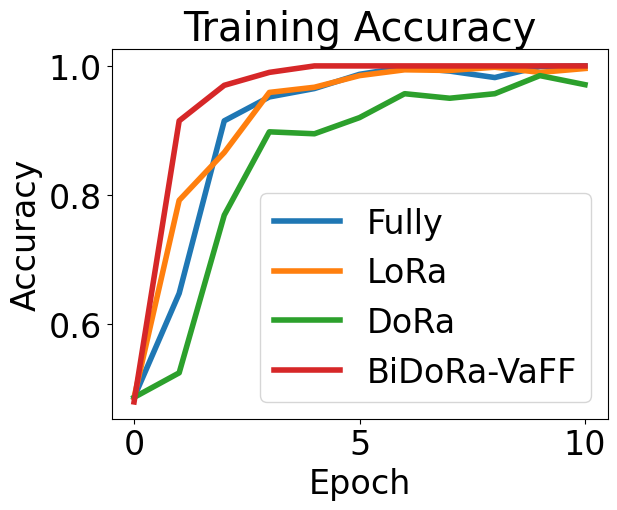

In [29]:
# output = (tr_acc,tr_loss), (test_acc,test_loss), (time_stamp)

# Tr Accuracy
plt.plot(range(num_epochs+1),output[0][0], label = "Fully")
plt.plot(range(num_epochs+1),output_lora[0][0], label = "LoRa")
plt.plot(range(num_epochs+1),output_dora[0][0], label = "DoRa")
# plt.plot(range(num_epochs+1),output_bidora[0][0], label = "BiDoRa")
plt.plot(range(num_epochs+1),output_bidora_vaff[0][0], label = "BiDoRa-VaFF")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()
plt.title("Training Accuracy")
plt.savefig(output_plot_dir+"tr_acc.pdf", bbox_inches='tight')

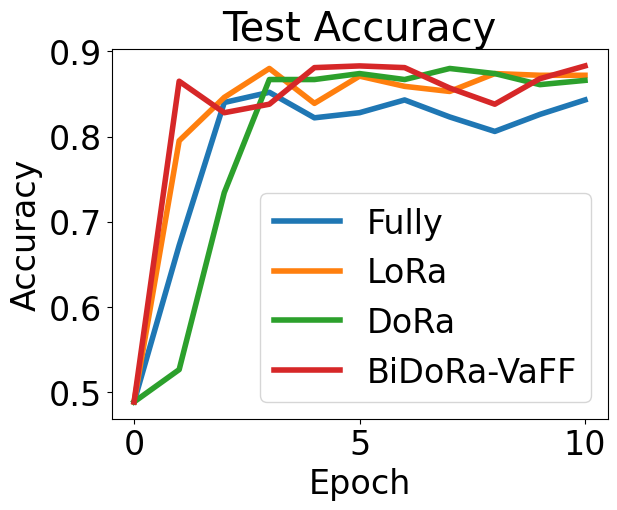

In [31]:
# Test Accuracy
plt.plot(range(num_epochs+1),output[1][0], label = "Fully")
plt.plot(range(num_epochs+1),output_lora[1][0], label = "LoRa")
plt.plot(range(num_epochs+1),output_dora[1][0], label = "DoRa")
# plt.plot(range(num_epochs+1),output_bidora[0][1], label = "BiDoRa")
plt.plot(range(num_epochs+1),output_bidora_vaff[1][0], label = "BiDoRa-VaFF")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()
plt.title("Test Accuracy")
plt.savefig(output_plot_dir+"te_acc.pdf", bbox_inches='tight')

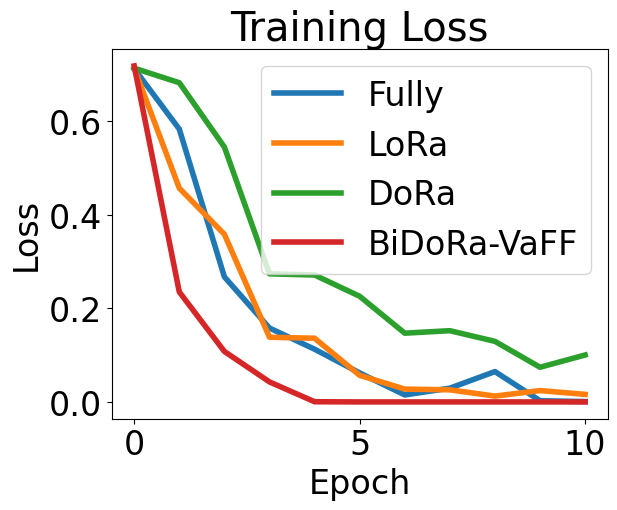

In [33]:
# output = (tr_acc,tr_loss), (test_acc,test_loss), (time_stamp)

# Tr Loss
plt.plot(range(num_epochs+1),output[0][1], label = "Fully")
plt.plot(range(num_epochs+1),output_lora[0][1], label = "LoRa")
plt.plot(range(num_epochs+1),output_dora[0][1], label = "DoRa")
# plt.plot(range(num_epochs+1),output_bidora[0][1], label = "BiDoRa")
plt.plot(range(num_epochs+1),output_bidora_vaff[0][1], label = "BiDoRa-VaFF")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.title("Training Loss")
plt.savefig(output_plot_dir+"tr_loss.pdf", bbox_inches='tight')

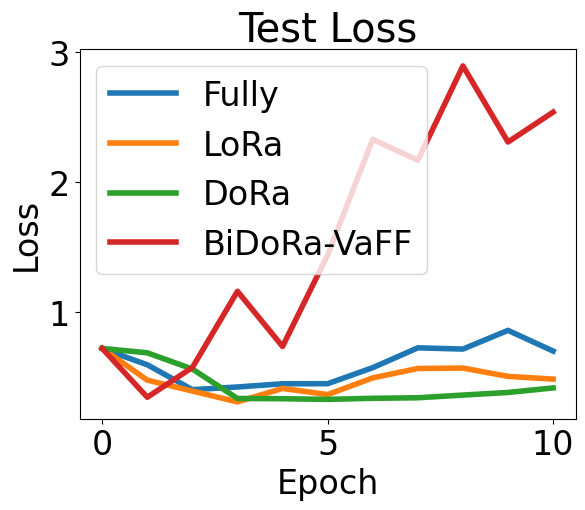

In [35]:
# Test loss
plt.plot(range(num_epochs+1),output[1][1], label = "Fully")
plt.plot(range(num_epochs+1),output_lora[1][1], label = "LoRa")
plt.plot(range(num_epochs+1),output_dora[1][1], label = "DoRa")
# plt.plot(range(num_epochs+1),output_bidora[1][1], label = "BiDoRa")
plt.plot(range(num_epochs+1),output_bidora_vaff[1][1], label = "BiDoRa-VaFF")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.title("Test Loss")
plt.savefig(output_plot_dir+"te_loss.pdf", bbox_inches='tight')

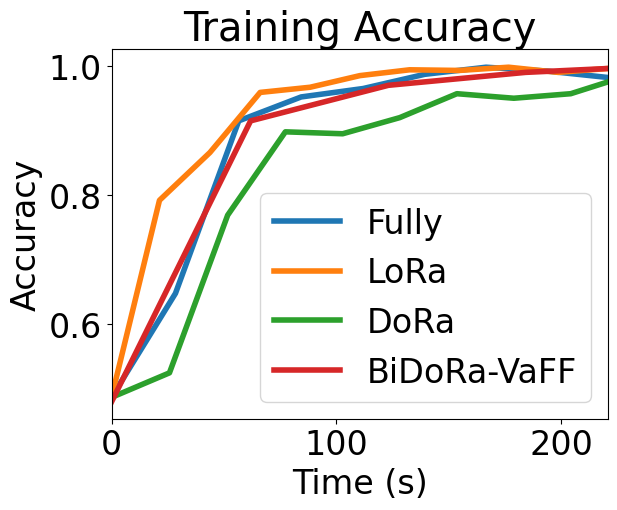

In [39]:
###### Time

# output = (tr_acc,tr_loss), (test_acc,test_loss), (time_stamp)

# Tr Accuracy
plt.plot(output[2],output[0][0], label = "Fully")
plt.plot(output_lora[2],output_lora[0][0], label = "LoRa")
plt.plot(output_dora[2],output_dora[0][0], label = "DoRa")
# plt.plot(output_bidora[2],output_bidora[0][0], label = "BiDoRa")
plt.plot(output_bidora_vaff[2],output_bidora_vaff[0][0], label = "BiDoRa-VaFF")

plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.xlim(0,output_lora[2][-1])

plt.legend()
plt.title("Training Accuracy")
plt.savefig(output_plot_dir+"tr_acc.pdf", bbox_inches='tight')

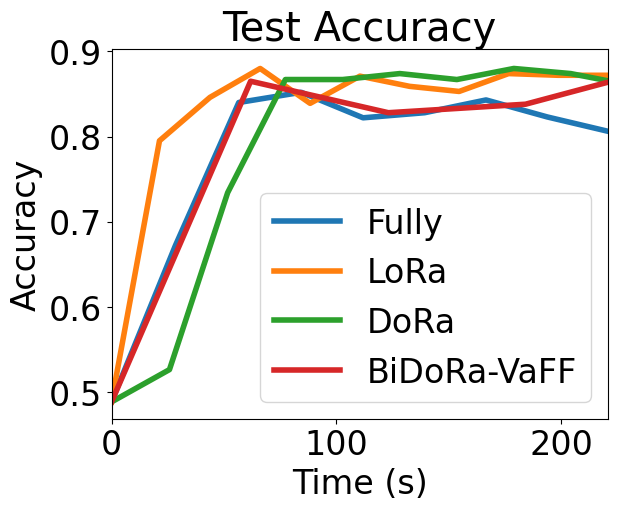

In [41]:
# Test Accuracy
plt.plot(output[2],output[1][0], label = "Fully")
plt.plot(output_lora[2],output_lora[1][0], label = "LoRa")
plt.plot(output_dora[2],output_dora[1][0], label = "DoRa")
# plt.plot(output_bidora[2],output_bidora[0][1], label = "BiDoRa")
plt.plot(output_bidora_vaff[2],output_bidora_vaff[1][0], label = "BiDoRa-VaFF")

plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.xlim([0,output_lora[2][-1]])

plt.legend()
plt.title("Test Accuracy")
plt.savefig(output_plot_dir+"te_acc.pdf", bbox_inches='tight')

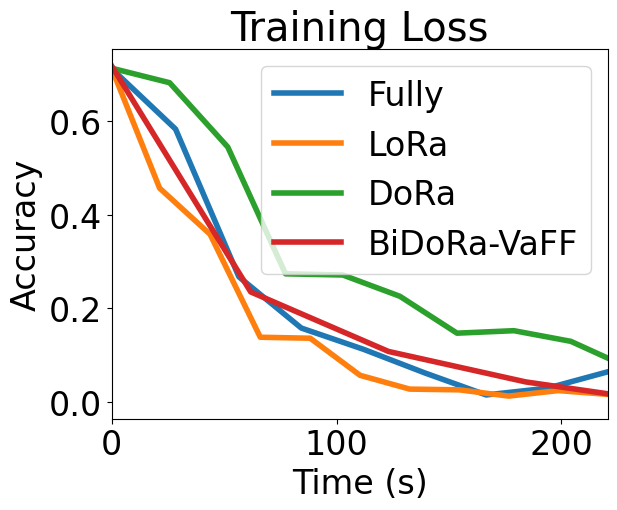

In [44]:
# output = (tr_acc,tr_loss), (test_acc,test_loss), (time_stamp)

# Tr Loss
plt.plot(output[2],output[0][1], label = "Fully")
plt.plot(output_lora[2],output_lora[0][1], label = "LoRa")
plt.plot(output_dora[2],output_dora[0][1], label = "DoRa")
# plt.plot(output_bidora[2],output_bidora[0][1], label = "BiDoRa")
plt.plot(output_bidora_vaff[2],output_bidora_vaff[0][1], label = "BiDoRa-VaFF")

plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.xlim([0,output_lora[2][-1]])

plt.legend()
plt.title("Training Loss")
plt.savefig(output_plot_dir+"tr_loss.pdf", bbox_inches='tight')